In [43]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
from yfinance import download

In [44]:
stock_list =["NIO","XPEV","JOBY","TSLA","LI"]
tick = stock_list[4]
tick

'LI'

In [51]:
data = download(tick, start='2010-01-01', end='2023-11-20')
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-07-30,15.490000,17.500000,15.100000,16.459999,16.459999,64611300
2020-07-31,16.670000,17.170000,15.990000,16.000000,16.000000,19532800
2020-08-03,16.260000,17.000000,15.770000,16.360001,16.360001,11740000
2020-08-04,16.549999,16.840000,15.950000,16.690001,16.690001,7781800
2020-08-05,16.649000,17.000000,16.400000,16.750000,16.750000,3991400
...,...,...,...,...,...,...
2023-11-13,38.060001,39.619999,38.000000,39.459999,39.459999,6057300
2023-11-14,39.590000,40.082001,39.130001,39.849998,39.849998,5174100
2023-11-15,40.400002,41.419998,40.369999,40.529999,40.529999,5387100


from matplotlib import pyplot as plt
data['Open'].plot(kind='hist', bins=20, title='Open')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data['High'].plot(kind='hist', bins=20, title='High')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data['Low'].plot(kind='hist', bins=20, title='Low')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data['Close'].plot(kind='hist', bins=20, title='Close')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data.plot(kind='scatter', x='Open', y='High', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data.plot(kind='scatter', x='High', y='Low', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data.plot(kind='scatter', x='Low', y='Close', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data.plot(kind='scatter', x='Close', y='Adj Close', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data['Open'].plot(kind='line', figsize=(8, 4), title='Open')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
data['High'].plot(kind='line', figsize=(8, 4), title='High')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
data['Low'].plot(kind='line', figsize=(8, 4), title='Low')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
data['Close'].plot(kind='line', figsize=(8, 4), title='Close')
plt.gca().spines[['top', 'right']].set_visible(False)

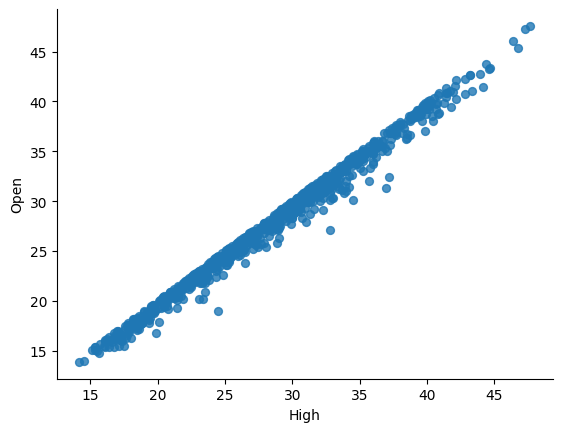

In [66]:
from matplotlib import pyplot as plt
data.plot(kind='scatter', x='High', y='Open', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

In [74]:
# Extracting relevant data columns: Closing prices and Volume
# We focus on the 'Close' column, which represents the stock's closing price,
# and the 'Volume' column, which represents the trading volume of the stock.
df = data[['Close', 'Volume']]

# Data normalization: Scaling the data to a common range [0, 1]
# This step ensures that all data values are within the same scale,
# which can improve the training process of the neural network.
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values)

# Creating the dataset for training and testing
# We prepare input sequences of historical data (X) and their corresponding future data (y).
# 'seq_length' is the number of previous data points used to predict the next data point.
seq_length = 40
X, y = [], []

# Loop through the scaled data to create input sequences and targets
for i in range(seq_length, len(scaled_data)):
    # For each iteration, collect the previous 'seq_length' data points as features
    X.append(scaled_data[i-seq_length:i])
    # The next data point after those 'seq_length' data points becomes the target variable
    y.append(scaled_data[i])

# Convert the collected data into numpy arrays for further processing
X = np.array(X)
y = np.array(y)

# Splitting the dataset into training and testing sets
# We use 80% of the data for training and the remaining 20% for testing
train_size = int(0.8 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Converting data to PyTorch tensors for model training and evaluation
# We reshape the data tensors to match the expected input shape of the model:
# (batch_size, num_features, sequence_length), which is different from the given shape.
# Permute is used to swap the last two dimensions.
X_train_tensor = torch.FloatTensor(X_train).permute(0, 2, 1)
y_train_tensor = torch.FloatTensor(y_train)

X_test_tensor = torch.FloatTensor(X_test).permute(0, 2, 1)
y_test_tensor = torch.FloatTensor(y_test)


In [75]:
X_train_tensor.shape

torch.Size([634, 2, 40])

In [76]:
y_train_tensor.shape

torch.Size([634, 2])

In [77]:
# Check for GPU availability and set the device accordingly
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [78]:
class MultiLayerCNNLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_lstm_layers, output_dim, kernel_size=3):
        super(MultiLayerCNNLSTM, self).__init__()

        # Store the number of LSTM layers and the hidden dimensionality
        self.num_lstm_layers = num_lstm_layers
        self.hidden_dim = hidden_dim

        # CNN Layers
        # ---------------
        self.cnn_layers = nn.Sequential(
            # First convolution layer. Input: [batch_size, input_dim, seq_length]
            nn.Conv1d(input_dim, 32, kernel_size=kernel_size, padding=1), # Output: [batch_size, 32, seq_length]
            nn.ReLU(), # Activation function

            # Second convolution layer
            nn.Conv1d(32, 64, kernel_size=kernel_size, padding=1), # Output: [batch_size, 64, seq_length]
            nn.ReLU(),

            # Max pooling to reduce the sequence length by half
            nn.MaxPool1d(2), # Output: [batch_size, 64, seq_length/2]

            # Third convolution layer
            nn.Conv1d(64, 128, kernel_size=kernel_size, padding=1), # Output: [batch_size, 128, seq_length/2]
            nn.ReLU(),

            # Another max pooling to reduce sequence length further
            nn.MaxPool1d(2)  # Output: [batch_size, 128, seq_length/4]
        )

        # LSTM Layers
        # ---------------
        # LSTM expects input of shape: [batch_size, seq_length, features].
        # Here, features is 128 (the output channels from the previous CNN layer)
        self.lstm = nn.LSTM(128, hidden_dim, num_lstm_layers, batch_first=True)

        # Fully connected layer to produce the final output
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Pass data through CNN layers
        x = self.cnn_layers(x)

        # Permute tensor dimensions to match the LSTM's expected input shape
        x = x.permute(0, 2, 1)  # Shape: [batch_size, seq_length, features]

        # Initialize LSTM hidden and cell states
        h0 = torch.zeros(self.num_lstm_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)
        c0 = torch.zeros(self.num_lstm_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # Pass data through LSTM layers.
        # Output shape: [batch_size, seq_length, hidden_dim]. We're interested in the last sequence step for the FC layer.
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Pass the output of the last sequence step through the Fully connected layer
        out = self.fc(out[:, -1, :])

        return out.squeeze(-1)


In [80]:
class ConvBiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_lstm_layers, output_dim, kernel_size=3):
        super(ConvBiLSTM, self).__init__()

        self.num_lstm_layers = num_lstm_layers
        self.hidden_dim = hidden_dim

        # Multiple CNN layers
        self.cnn_layers = nn.Sequential(
            nn.Conv1d(input_dim, 32, kernel_size=kernel_size, padding=1),
            nn.ReLU(),  # Activation function
            nn.Conv1d(32, 64, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2),  # Pooling to reduce dimensionality
            nn.Conv1d(64, 128, kernel_size=kernel_size, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )

        # Bi-directional LSTM layers
        self.bilstm = nn.LSTM(128, hidden_dim, num_layers=num_lstm_layers, batch_first=True, bidirectional=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # Multiplying by 2 for bidirectional

    def forward(self, x):
        # Pass data through CNN layers
        x = self.cnn_layers(x)

        x = x.permute(0, 2, 1)  # Shape: [batch_size, seq_length, features]

        # Initialize LSTM hidden and cell states
        h0 = torch.zeros(self.num_lstm_layers * 2, x.size(0), self.hidden_dim).requires_grad_().to(device)  # * 2 for bidirectional
        c0 = torch.zeros(self.num_lstm_layers * 2, x.size(0), self.hidden_dim).requires_grad_().to(device)

        # Pass data through BiLSTM layers
        out, (hn, cn) = self.bilstm(x, (h0.detach(), c0.detach()))

        # Pass the output of BiLSTM layer to Fully connected layer
        out = self.fc(out[:, -1, :])

        return out.squeeze(-1)

In [89]:
# Create an instance of the ConvBiLSTM model
input_dim = 2  # Two features: closing price and volume
hidden_dim = 128
num_lstm_layers = 1
output_dim = 2
kernel_size = 3

num_epochs = 500

#model = ConvBiLSTM(input_dim, hidden_dim, num_lstm_layers, output_dim, kernel_size)
model = MultiLayerCNNLSTM(input_dim, hidden_dim, num_lstm_layers, output_dim, kernel_size)
model.to(device)

# Training the model
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.MSELoss()

for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensor.to(device))  # Permute the input tensor dimensions
    loss = criterion(outputs, y_train_tensor.squeeze().to(device))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # Print the loss every 10 epochs
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [50/500], Loss: 0.0096
Epoch [100/500], Loss: 0.0036
Epoch [150/500], Loss: 0.0027
Epoch [200/500], Loss: 0.0022
Epoch [250/500], Loss: 0.0019
Epoch [300/500], Loss: 0.0017
Epoch [350/500], Loss: 0.0016
Epoch [400/500], Loss: 0.0015
Epoch [450/500], Loss: 0.0014
Epoch [500/500], Loss: 0.0014


In [90]:
# Evaluation and plotting
# Put the model in evaluation mode
model.eval()

# Get predictions for training and testing sets
train_preds = model(X_train_tensor.to(device)).detach().cpu().numpy()
test_preds = model(X_test_tensor.to(device)).detach().cpu().numpy()

# Reshape the predictions and actuals to match shapes
train_preds = train_preds.reshape(-1, 2)  # Two features: closing price and volume
test_preds = test_preds.reshape(-1, 2)

# Inverse scaling of the predictions
train_preds_unscaled = scaler.inverse_transform(train_preds)
test_preds_unscaled = scaler.inverse_transform(test_preds)

# Inverse scaling of the actuals
y_train_unscaled = scaler.inverse_transform(y_train)
y_test_unscaled = scaler.inverse_transform(y_test)

# Extract dates for plotting
train_dates = nio_df.index[seq_length:seq_length+len(y_train)]
test_dates = nio_df.index[seq_length+len(y_train):]

# Create a Plotly figure for closing prices
fig_closing = go.Figure()

# Plotting actual train closing prices
fig_closing.add_trace(go.Scatter(x=train_dates, y=y_train_unscaled[:, 0], mode='lines', name='Actual Train Closing Prices'))

# Plotting predicted train closing prices
fig_closing.add_trace(go.Scatter(x=train_dates, y=train_preds_unscaled[:, 0], mode='lines', name='Predicted Train Closing Prices'))

# Plotting actual test closing prices
fig_closing.add_trace(go.Scatter(x=test_dates, y=y_test_unscaled[:, 0], mode='lines', name='Actual Test Closing Prices'))

# Plotting predicted test closing prices
fig_closing.add_trace(go.Scatter(x=test_dates, y=test_preds_unscaled[:, 0], mode='lines', name='Predicted Test Closing Prices'))

# Customize the layout of the closing price plot
fig_closing.update_layout(title=f'{tick} Stock Closing Price Predictions',
                          xaxis_title='Date',
                          yaxis_title='Closing Price')

# Display the closing price plot
fig_closing.show()

# Create a Plotly figure for volume
fig_volume = go.Figure()

# Plotting actual train volumes
fig_volume.add_trace(go.Scatter(x=train_dates, y=y_train_unscaled[:, 1], mode='lines', name='Actual Train Volumes'))

# Plotting predicted train volumes
fig_volume.add_trace(go.Scatter(x=train_dates, y=train_preds_unscaled[:, 1], mode='lines', name='Predicted Train Volumes'))

# Plotting actual test volumes
fig_volume.add_trace(go.Scatter(x=test_dates, y=y_test_unscaled[:, 1], mode='lines', name='Actual Test Volumes'))

# Plotting predicted test volumes
fig_volume.add_trace(go.Scatter(x=test_dates, y=test_preds_unscaled[:, 1], mode='lines', name='Predicted Test Volumes'))

# Customize the layout of the volume plot
fig_volume.update_layout(title=f'{tick} Stock Volume Predictions',
                         xaxis_title='Date',
                         yaxis_title='Volume')

# Display the volume plot
fig_volume.show()


In [92]:
# Convert the last sequence from testing data to a PyTorch tensor
input_sequence = torch.FloatTensor(X_test_tensor[-1]).unsqueeze(0).to(device)

# Initialize lists to store predicted values for closing price and volume
predictions = []

# Loop over the number of days for which we want to predict (approximately 2 months)
for _ in range(30):
    # Use the model to make a prediction based on the current input_sequence
    prediction = model(input_sequence.to(device))

    # store the predicted values
    predictions.append(prediction.detach().cpu().numpy())

    # Create a new input sequence for the next prediction
    # This is done by removing the oldest values from the input_sequence and appending the current predictions to it
    new_input = prediction.unsqueeze(2)  # Add a new dimension for sequence length
    input_sequence = torch.cat([input_sequence[:, :, 1:], new_input], dim=2)


In [93]:
predictions_unscaled = scaler.inverse_transform(np.array(predictions).reshape(-1, 2))

In [97]:
#predictions_unscaled

In [98]:
  closing_pred = predictions_unscaled[:, 0]
  volume_pred = predictions_unscaled[:, 1]


In [99]:
closing_pred.shape

(30,)

In [101]:
# Create a sequence of dates for the next 2 months
last_date = df.index[-1]
next_dates = pd.date_range(start=last_date, periods=60, freq='D')[1:]

# Create a Plotly figure for predicted closing prices
fig_closing_pred = go.Figure()

# Plotting predicted closing prices for the next 2 months
fig_closing_pred.add_trace(go.Scatter(x=next_dates, y=closing_pred.flatten(), mode='lines', name='Predicted Closing Prices'))

# Customize the layout of the predicted closing price plot
fig_closing_pred.update_layout(title='NIO Stock Predicted Closing Prices for the Next 2 Months',
                               xaxis_title='Date',
                               yaxis_title='Closing Price')

# Display the predicted closing price plot
fig_closing_pred.show()

# Create a Plotly figure for predicted volumes
fig_volume_pred = go.Figure()

# Plotting predicted volumes for the next 2 months
fig_volume_pred.add_trace(go.Scatter(x=next_dates, y=volume_pred.flatten(), mode='lines', name='Predicted Volumes'))

# Customize the layout of the predicted volume plot
fig_volume_pred.update_layout(title=f'{tick} Stock Predicted Volumes for the Next 2 Months',
                              xaxis_title='Date',
                              yaxis_title='Volume')

# Display the predicted volume plot
fig_volume_pred.show()
